# Key Concepts

* Key Components
    * Search Spaces
    * Trainables (objective function)
    * Search Algorithms
    * Schedulers
    * Trials
    * Analyses

* Overview: <br>
    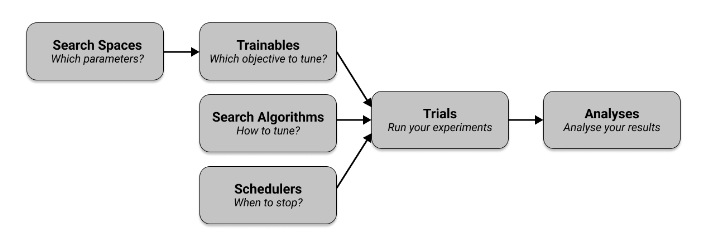 <br>



### Ray Tune Trainables

* A `Trainable` is an object that you can pass into a Tune run. Tune has 2 ways of defining a `trainable`: Function API and Class API. Trainables can return:
    * `train.report(...)`: Report the (intermediate) score to Tune. Do not use in Class Trainables.
    * `dict`: e.g., `{'score':score}`, simply return (or yield) the score at the end of the trainable function.

In [1]:
import ray

context = ray.init()
print(context.dashboard_url)

2024-11-08 08:45:53,945	INFO worker.py:1807 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


127.0.0.1:8265


In [2]:
from ray import train, tune

def objective(x, a, b):
    return a * (x ** 0.5) + b

def trainable(config: dict):
    intermediate_score = 0
    for x in range(20):
        intermediate_score = objective(x, config["a"], config["b"])
        train.report({"score": intermediate_score})  # This sends the score to Tune.


tuner = tune.Tuner(trainable, param_space={"a": 2, "b": 4})
results = tuner.fit()

2024-11-08 08:46:13,876	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/trainable_2024-11-08_08-45-59' in 0.0091s.
2024-11-08 08:46:13,895	INFO tune.py:1041 -- Total run time: 14.11 seconds (7.96 seconds for the tuning loop).


In [4]:
!ray summary tasks


======== Tasks Summary: 2024-11-08 08:46:33.517159 ========
Stats:
------------------------------------
total_actor_scheduled: 1
total_actor_tasks: 24
total_tasks: 1


Table (group by func_name):
------------------------------------
    FUNC_OR_CLASS_NAME                    STATE_COUNTS    TYPE
0   ImplicitFunc.train                    FINISHED: 21    ACTOR_TASK
1   ImplicitFunc.get_auto_filled_metrics  FINISHED: 1     ACTOR_TASK
2   ImplicitFunc.__ray_ready__            FINISHED: 1     ACTOR_TASK
3   bundle_reservation_check_func         FINISHED: 1     NORMAL_TASK
4   ImplicitFunc.stop                     FINISHED: 1     ACTOR_TASK
5   ImplicitFunc.__init__                 FINISHED: 1     ACTOR_CREATION_TASK



### Ray Tune Search Spaces
* A search space defines valid values for your hyperparameters and can specify how these values are sampled (e.g. from a uniform distribution or a normal distribution).
* Tune offers various functions to define search spaces and sampling methods: [Link](https://docs.ray.io/en/latest/tune/api/search_space.html#tune-search-space)

In [7]:
config = {
    # Sample a float uniformly between -5.0 and -1.0
    "uniform": tune.uniform(-5, -1),

    # Sample a float uniformly between 3.2 and 5.4,
    # rounding to multiples of 0.2
    "quniform": tune.quniform(3.2, 5.4, 0.2),

    # Sample a float uniformly between 0.0001 and 0.01, while
    # sampling in log space
    "loguniform": tune.loguniform(1e-4, 1e-2),

    # Sample a float uniformly between 0.0001 and 0.1, while
    # sampling in log space and rounding to multiples of 0.00005
    "qloguniform": tune.qloguniform(1e-4, 1e-1, 5e-5),

    # Sample a random float from a normal distribution with
    # mean=10 and sd=2
    "randn": tune.randn(10, 2),

    # Sample a random float from a normal distribution with
    # mean=10 and sd=2, rounding to multiples of 0.2
    "qrandn": tune.qrandn(10, 2, 0.2),

    # Sample a integer uniformly between -9 (inclusive) and 15 (exclusive)
    "randint": tune.randint(-9, 15),

    # Sample a random uniformly between -21 (inclusive) and 12 (inclusive (!))
    # rounding to multiples of 3 (includes 12)
    # if q is 1, then randint is called instead with the upper bound exclusive
    "qrandint": tune.qrandint(-21, 12, 3),

    # Sample a integer uniformly between 1 (inclusive) and 10 (exclusive),
    # while sampling in log space
    "lograndint": tune.lograndint(1, 10),

    # Sample a integer uniformly between 1 (inclusive) and 10 (inclusive (!)),
    # while sampling in log space and rounding to multiples of 2
    # if q is 1, then lograndint is called instead with the upper bound exclusive
    "qlograndint": tune.qlograndint(1, 10, 2),

    # Sample an option uniformly from the specified choices
    "choice": tune.choice(["a", "b", "c"]),

    # Sample from a random function, in this case one that
    # depends on another value from the search space
    "func": tune.sample_from(lambda spec: spec.config.uniform * 0.01),

    # Do a grid search over these values. Every value will be sampled
    # ``num_samples`` times (``num_samples`` is the parameter you pass to ``tune.TuneConfig``,
    # which is taken in by ``Tuner``)
    "grid": tune.grid_search([32, 64, 128])
}

### Tune Trials

* use `Tuner.fit(...)` to execute and manage hyperparameter tuning and generate your `trials`.
    * At a minimum, your `Tuner` call takes in a trainable as first argument, and a `param_space` dictionary to define the search space.
    * It also provides many features such as logging, checkpointing, and early stopping.
    * It will generate a couple of hyperparameter configurations from its arguments, wrapping them into `Trial` objects.
        * A `Trial` object holds the state for one model training run.

In [11]:
space = {"a": tune.uniform(0, 1), "b": tune.uniform(0, 1)}
tuner = tune.Tuner(
    trainable, param_space=space, tune_config=tune.TuneConfig(num_samples=10)
)
tuner.fit()

results = tuner.fit()

2024-11-08 09:42:50,536	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/trainable_2024-11-08_09-42-29' in 0.0604s.
2024-11-08 09:42:50,571	INFO tune.py:1041 -- Total run time: 10.41 seconds (10.28 seconds for the tuning loop).


In [12]:
print(
    results.get_best_result(metric='score', mode='min').config
)

{'a': 0.095029554834962, 'b': 0.31940156398013086}


### Tune Search Algorithms

* Default Search Algorithm is random
* [Available search algorithms in Tune](https://docs.ray.io/en/latest/tune/key-concepts.html)
* [Search Algorithms APIs](https://docs.ray.io/en/latest/tune/api/suggestion.html#tune-search-alg)

In [20]:
from ray.tune.search.optuna import OptunaSearch

In [21]:
search_space = {"a": tune.uniform(0, 1), "b": tune.uniform(0, 20)}

algo = OptunaSearch()

tuner = tune.Tuner(
    trainable,
    tune_config=tune.TuneConfig(
        metric='score', mode='min', search_alg=algo
    ),
    run_config=train.RunConfig(stop={'training_iteration':20}),
    param_space=search_space
)

tuner.fit()

2024-11-08 10:13:47,439	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/trainable_2024-11-08_10-13-42' in 0.0133s.
2024-11-08 10:13:47,456	INFO tune.py:1041 -- Total run time: 4.64 seconds (4.60 seconds for the tuning loop).


ResultGrid<[
  Result(
    metrics={'score': 5.5843927682860155},
    path='C:/Users/JCA/ray_results/trainable_2024-11-08_10-13-42/trainable_43483a0b_1_a=0.9892,b=1.2725_2024-11-08_10-13-42',
    filesystem='local',
    checkpoint=None
  )
]>

# Quickstart

In [ ]:

def objective(config):
    score = config['a']**2 + config['b']
    return {'score':score}

search_space = {
    'a': tune.grid_search([0.001, 0.01, 0.1, 1.0]),
    'b': tune.choice([1, 2, 3])
}

tuner = tune.Tuner(objective, param_space = search_space)

results = tuner.fit()

2024-11-08 08:03:25,524	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/JCA/ray_results/objective_2024-11-08_08-03-19' in 0.0191s.
2024-11-08 08:03:25,549	INFO tune.py:1041 -- Total run time: 6.29 seconds (6.23 seconds for the tuning loop).


In [ ]:
print(
    results.get_best_result(metric='score', mode='min').config
)

{'a': 0.01, 'b': 1}


In [ ]:
results.get_dataframe()

,score,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/a,config/b,logdir
0,2.000001,1731024205,None,False,1,dc73b_00000,2024-11-08_08-03-25,0.000313,0.000313,15276,JCA,127.0.0.1,0.000313,1,0.001,2,dc73b_00000
1,1.000100,1731024205,None,False,1,dc73b_00001,2024-11-08_08-03-25,0.001007,0.001007,32308,JCA,127.0.0.1,0.001007,1,0.010,1,dc73b_00001
2,1.010000,1731024205,None,False,1,dc73b_00002,2024-11-08_08-03-25,0.000000,0.000000,31572,JCA,127.0.0.1,0.000000,1,0.100,1,dc73b_00002
3,4.000000,1731024205,None,False,1,dc73b_00003,2024-11-08_08-03-25,0.001011,0.001011,31188,JCA,127.0.0.1,0.001011,1,1.000,3,dc73b_00003
